# Membuat Classifier nya

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Reshape, LSTM, Input, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


In [94]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

# Image Processing

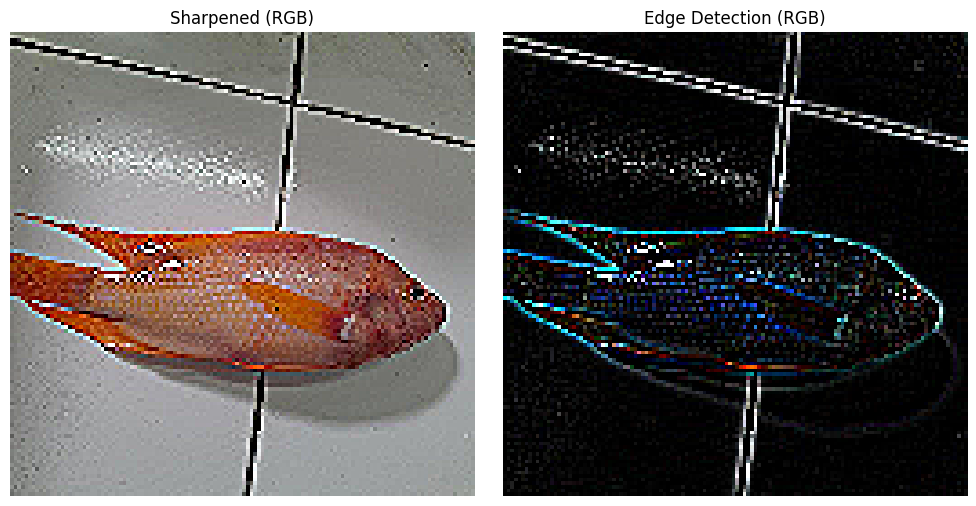

In [95]:
def image_preprocessing(image_path):
    # Baca gambar
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE))

    # Edge detection menggunakan kernel manual
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    
    edges = cv2.filter2D(img, -1, kernel_edge)

    # Sharpening pada RGB
    kernel_sharpen = np.array([[0, -1, 0],
                            [-1,  5, -1],
                            [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpen)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(sharpened)
    axes[0].set_title('Sharpened (RGB)')
    axes[0].axis('off')
    
    axes[1].imshow(edges)
    axes[1].set_title('Edge Detection (RGB)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Jalankan fungsi
image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg" 
# image_path = "new_data/WhatsApp Image 2022-11-05 at 22.42.11.jpg" 
image_preprocessing(image_path)




## Membuat dataset generatornya dan mendefenisikan data Generatornya

### Augmentasi Data dan Normalisasi data

In [96]:
# Custom ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def preprocessing_function(self, img):
        return image_preprocessing(img)

In [97]:
# Data Generators dengan preprocessing
train_datagen = CustomImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGenerator(rescale=1.0 / 255.0)

## Mendefinisikan asal folder sumber file berasal

In [98]:
# Directories (Adjust paths as needed)
train_dir = 'dataset/train/'
val_dir = 'dataset/valid/'
test_dir = 'dataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 2721 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [99]:
labels

dict_keys(['mujahir', 'red_devil', 'sepat'])

# Visualisasi Data

Visualisasi data dengan train:


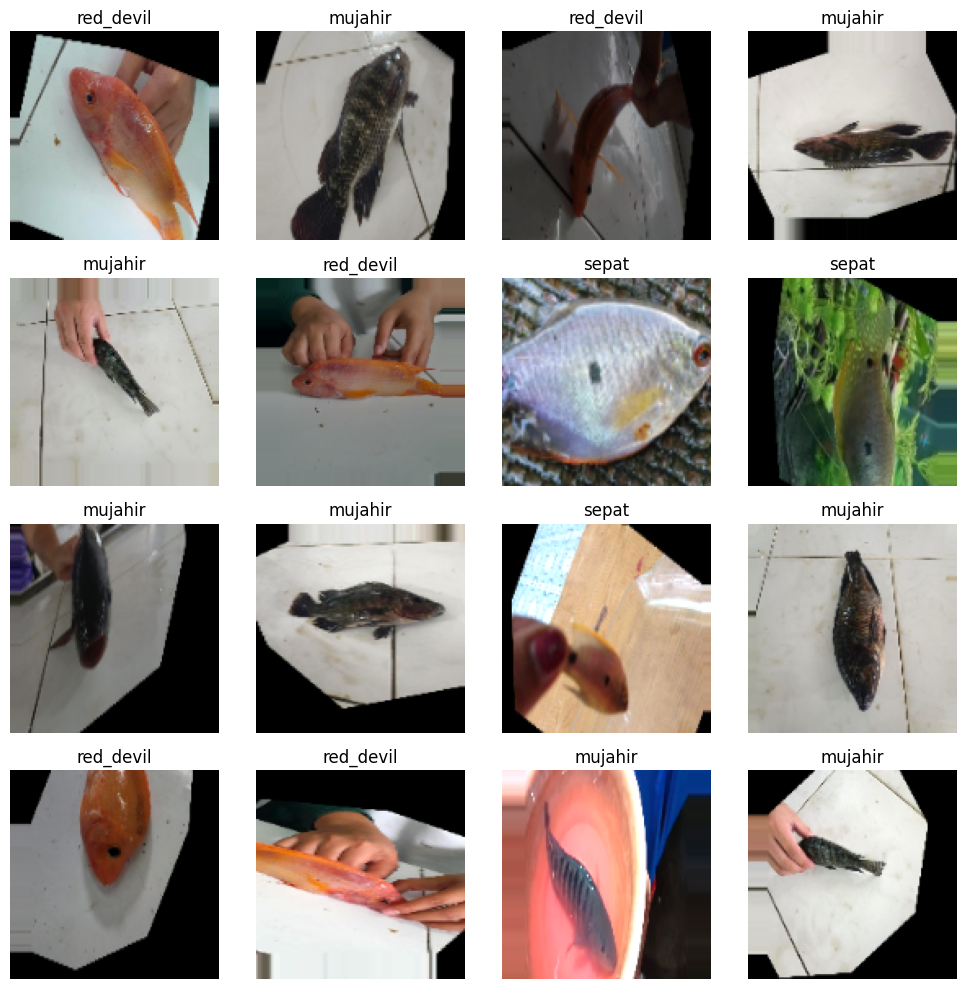

In [100]:
def plot_augmented_images(generator, labels, num_images=16):
    """Visualisasi gambar dari generator dengan augmentasi"""
    images, labels_batch = next(generator)
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch]

    plt.figure(figsize=(10,10))
    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualisasi contoh data augmentasi
print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)

### Grid Gambar dari Setiap Kelas

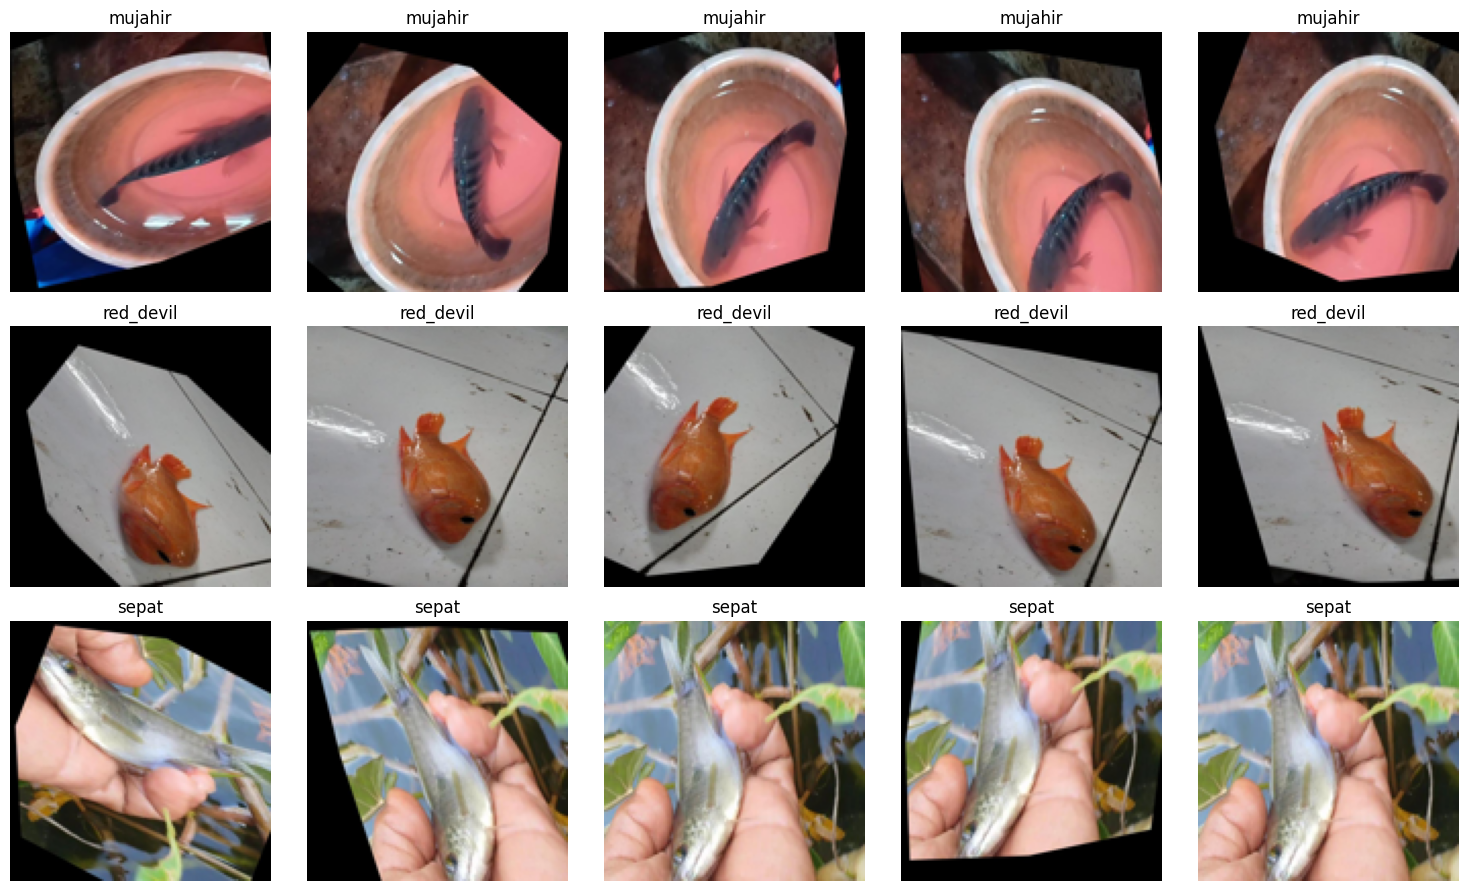

In [101]:
import os
from PIL import Image  # Menambahkan impor Image dari PIL
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size=(80, 80), samples_per_class=5):
    """Visualisasi beberapa gambar dari setiap kelas dalam dataset."""
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\M S I\AppData\Local\Temp\ipykernel_28056\1621613967.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


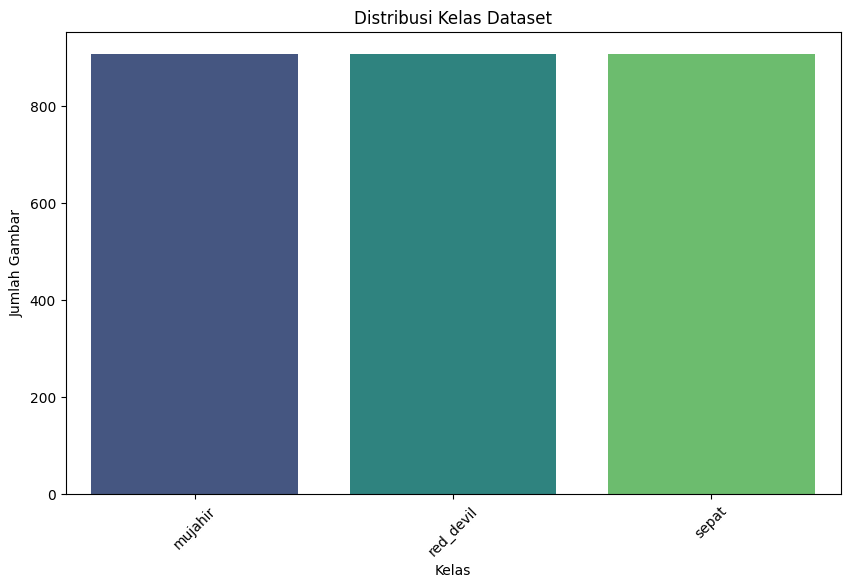

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes)  # Menghitung jumlah gambar per kelas
    class_names = list(generator.class_indices.keys())  # Mendapatkan nama kelas
    counts = [class_counts[i] for i in range(len(class_names))]  # Menyusun jumlah per kelas

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


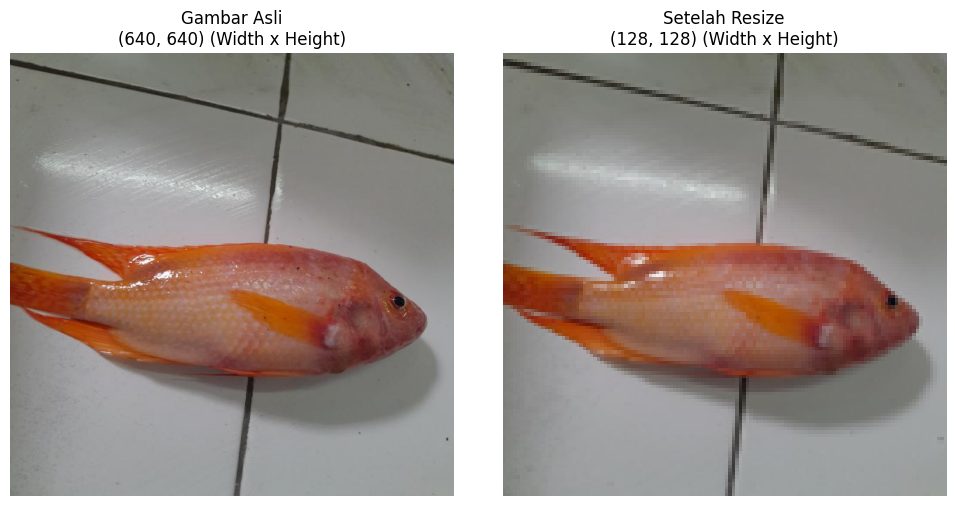

In [103]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_original_and_resized(image_path, target_size):
    """Menampilkan gambar asli dan gambar yang sudah diubah ukurannya"""
    try:
        # Membuka gambar asli
        img_original = Image.open(image_path)
        img_original_array = np.array(img_original)

        # Mengubah ukuran gambar
        img_resized = img_original.resize(target_size)
        img_resized_array = np.array(img_resized)

        # Visualisasi
        plt.figure(figsize=(10, 5))

        # Gambar asli
        plt.subplot(1, 2, 1)
        plt.imshow(img_original_array)
        plt.title(f"Gambar Asli\n{img_original.size} (Width x Height)")
        plt.axis("off")

        # Gambar yang diubah ukurannya
        plt.subplot(1, 2, 2)
        plt.imshow(img_resized_array)
        plt.title(f"Setelah Resize\n{target_size} (Width x Height)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File tidak ditemukan: {image_path}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Contoh penggunaan dengan jalur manual
example_image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg"
if os.path.exists(example_image_path):
    visualize_original_and_resized(example_image_path, IMG_SIZE)
else:
    print("Jalur gambar tidak ditemukan. Pastikan Anda memasukkan jalur yang benar.")


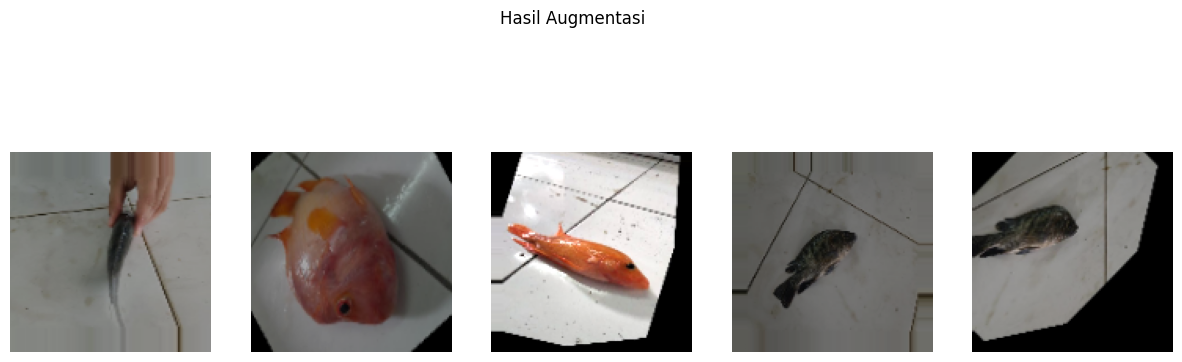

In [104]:
def visualize_augmentation(generator, num_images=5):
    """Visualisasi hasil augmentasi gambar."""
    images, _ = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
    plt.suptitle("Hasil Augmentasi")
    plt.show()

# Contoh penggunaan
visualize_augmentation(train_generator)


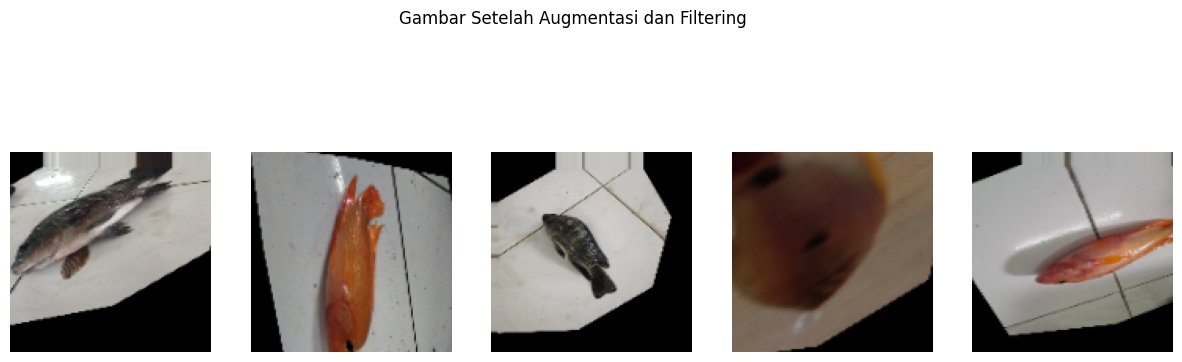

In [105]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

# Mengubah generator data Python Menjadi dataset TensorFlow

agar dapat digunakan dalam pipeline pelatihan, validasi, atau pengujian model secara efisien. Dengan ini, data dapat diproses dalam batch kecil langsung dari generator, mendukung augmentasi, dan tetap hemat memori.

In [106]:
# Define TF Data Generator
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, INPUT_SHAPE)
val_data = tf_data_generator(validation_generator, INPUT_SHAPE)
test_data = tf_data_generator(test_generator, INPUT_SHAPE)


# ANN

In [107]:
# # Model ANN (Artificial Neural Network)
# model = Sequential([
#     Input(shape=INPUT_SHAPE),
#     Flatten(),
    
#     Dense(1024, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(256, activation='relu'),              
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(32, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    

#     Dense(NUM_CLASSES, activation='softmax')
# ])


# # Summary Model
# model.summary()


In [108]:
model = Sequential([
    Input(shape=INPUT_SHAPE),
    Flatten(),
    
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),              
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(NUM_CLASSES, activation='softmax')
])

# Prebuild model

### Build Base Model

In [109]:
from tensorflow.keras.applications import MobileNet

# get base models
base_model = MobileNet(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    classes=NUM_CLASSES,
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 17s 1us/step


# add to top layer

In [110]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()


### Build Base model

In [111]:
from efficientnet.tfkeras import EfficientNetB1

# get base models
base_model = EfficientNetB1(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='noisy-student',
    classes=NUM_CLASSES,
)

### Add top network layer to models

In [112]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


# Hyperparameter Tuning

In [113]:
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

In [114]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [115]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [116]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [117]:
# # Summary Model
# model.summary()

In [118]:
# Training model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25


c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 225s 978ms/step - accuracy: 0.8717 - loss: 0.2796 - val_accuracy: 0.9630 - val_loss: 0.1120 - learning_rate: 5.0000e-04
Epoch 2/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9858 - loss: 0.0513 - val_accuracy: 0.9959 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 3/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9856 - loss: 0.0537 - val_accuracy: 0.9918 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Epoch 4/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 149s 863ms/step - accuracy: 0.9800 - loss: 0.0703 - val_accuracy: 0.9959 - val_loss: 0.0102 - learning_rate: 5.0000e-04
Epoch 5/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 149s 866ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 0.9877 - val_loss: 0.0278 - learning_rate: 5.0000e-04
Epoch 6/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 142s 828ms/step - accuracy: 0.9844 - loss: 0.0509 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 7/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - ac

In [119]:
# Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.9848e-04
Test Accuracy: 1.00


In [120]:
history.history['loss']

[0.11636801064014435,
 0.034559085965156555,
 0.05846580117940903,
 0.05323956906795502,
 0.013514936901628971,
 0.042675308883190155,
 0.061237625777721405,
 0.006760142743587494,
 0.004077909979969263,
 0.023997357115149498]

In [121]:
history.history['accuracy']

[0.9525909423828125,
 0.9889746308326721,
 0.9841969609260559,
 0.9852995276451111,
 0.9952223300933838,
 0.9871370792388916,
 0.9856670498847961,
 0.9974274039268494,
 0.9988974928855896,
 0.9977949261665344]

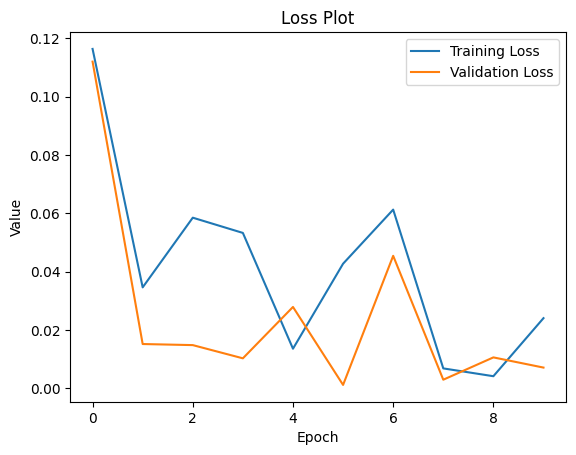

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

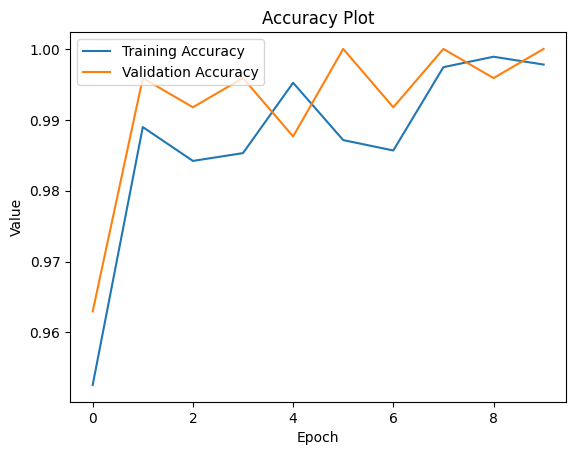

In [123]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [124]:
# plot_learning_rate(history)

In [125]:
model.save('../model/my_model.keras')


# Evaluate Models

In [126]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')   

Accuracy on training data: 1.0000 
Loss on training data: 0.0001 

Accuracy on test data: 1.0000 
Loss on test data: 0.0001 



## Pengujian Prediksi dengan Model Checkpoint


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step


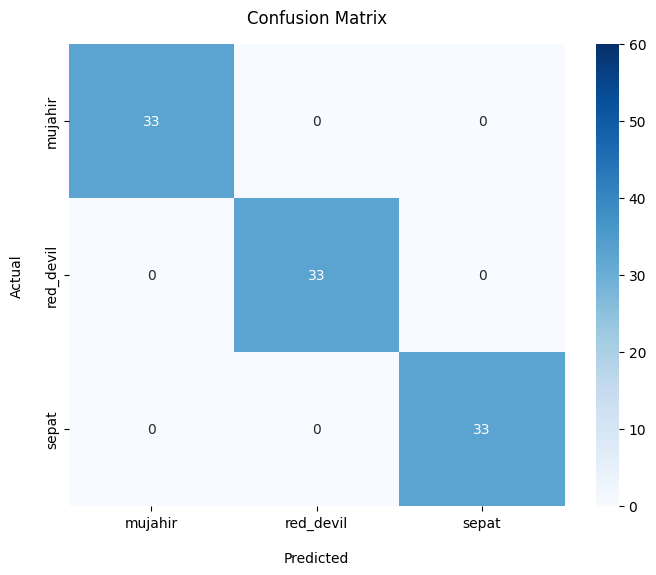

              precision    recall  f1-score   support

     mujahir       1.00      1.00      1.00        33
   red_devil       1.00      1.00      1.00        33
       sepat       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Muat model checkpoint
checkpoint = load_model('../model/my_model.keras')

# Evaluasi model terbaik pada data uji
predictions = checkpoint.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Label sebenarnya dari dataset uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Hitung confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

# Mendapatkan metrik evaluasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Identifikasi prediksi yang salah
misclassified_indices = np.where(true_classes != predicted_classes)[0]

# Menampilkan gambar yang diprediksi salah beserta label yang benar dan yang diprediksi
for idx in misclassified_indices:
    # Ambil nama gambar dari generator
    img_path = test_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    # Muat dan tampilkan gambar
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [128]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.models import load_model

# # Muat model checkpoint
# checkpoint = load_model('../model/my_model.keras')

# # Evaluasi model terbaik pada data uji
# predictions = checkpoint.predict(test_generator)
# predicted_classes = np.argmax(predictions, axis=1)

# # Label sebenarnya dari dataset uji
# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())

# # Hitung confusion matrix
# confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# # Tampilkan confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
# plt.xlabel('Predicted', labelpad=15)
# plt.ylabel('Actual', labelpad=15)
# plt.title('Confusion Matrix', pad=15)
# plt.show()

# # Mendapatkan metrik evaluasi
# report = classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

# Pengujuian Model

In [129]:
from tensorflow.keras.models import load_model

# Memuat model SavedModel
loaded_model = load_model('../model/my_model.keras')

# Menampilkan ringkasan model untuk memastikan berhasil dimuat
# print(loaded_model.summary())



Predictions for class: mujahir
Processing dataset/test/mujahir\1_mp4-0012_jpg.rf.af408cddf66ccba558575e67d654671a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processing dataset/test/mujahir\3_mp4-0001_jpg.rf.78c9387cea52f16b363b97e29b2224b4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Processing dataset/test/mujahir\3_mp4-0007_jpg.rf.bad24d31e5fd7ac75000cc3bfa89e488.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Processing dataset/test/mujahir\3_mp4-0009_jpg.rf.7a6de95452636bd2a742b23d4faf81cd.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/mujahir\5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Processing dataset/test/mujahir\6_mp4-0000_jpg.rf.977683a3c9107b8fb33a5b971cbebd3b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processing dataset/test/mujahir\6_mp4-0010_jpg.rf.0d2f29000f8d072d3f12176aa3aa6ef0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/mujahir\6_mp4-0013_jpg.rf.5e66c2d053fe7b1484bd8c6e

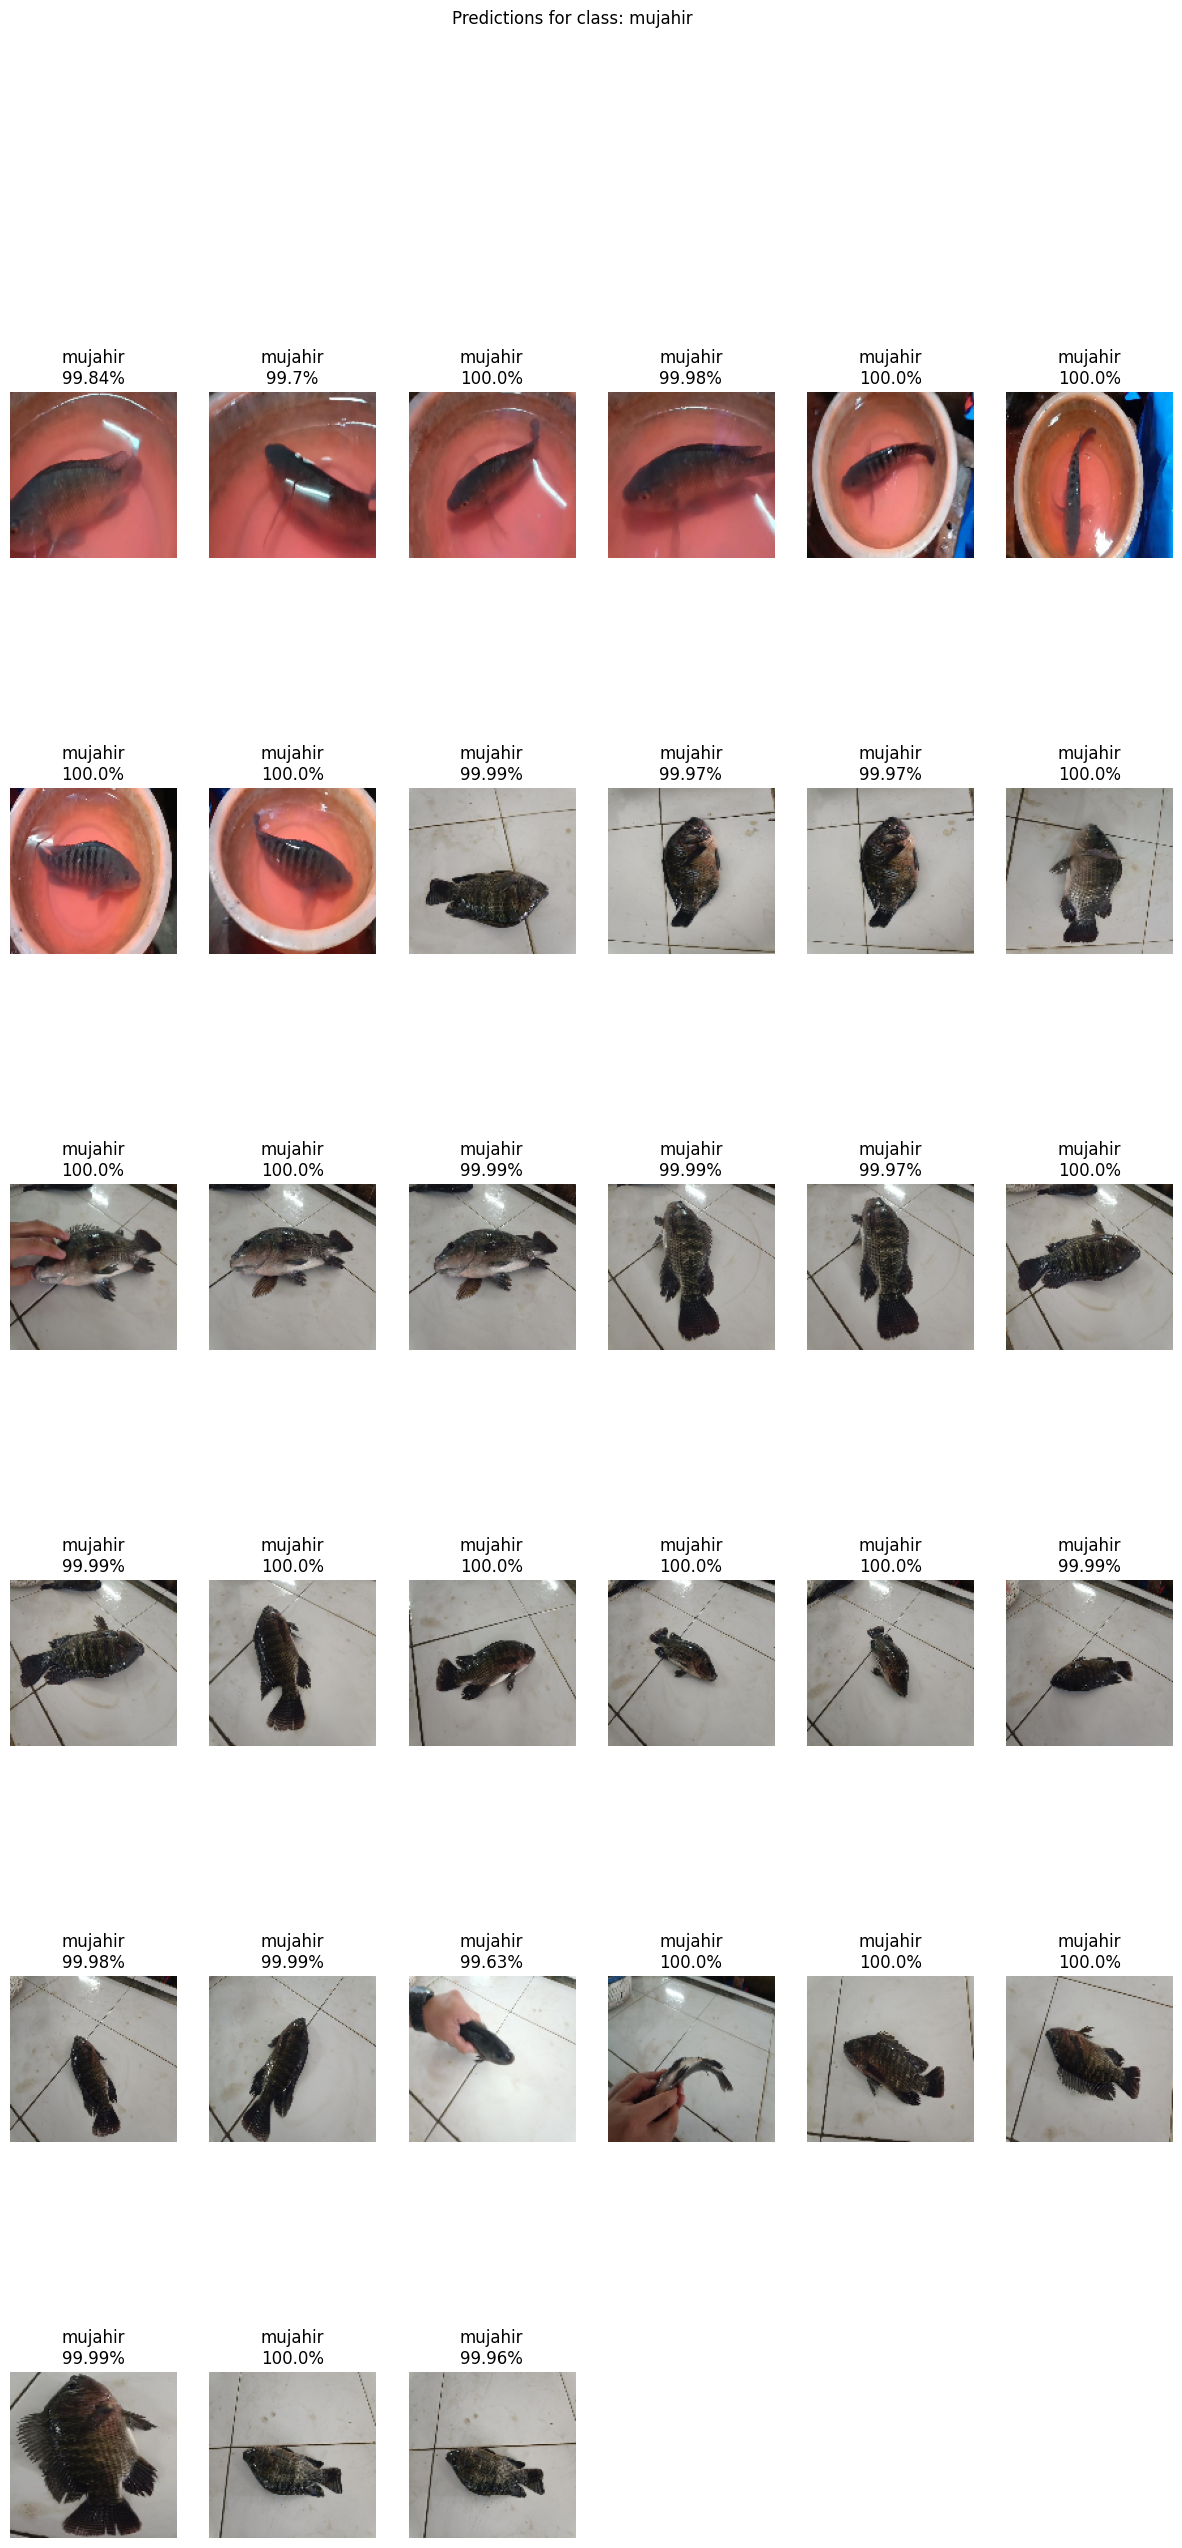


Predictions for class: red_devil
Processing dataset/test/red_devil\Red-Devil-101_png_jpg.rf.d9ed07b6e68c3e93176715b0010a3e33.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processing dataset/test/red_devil\Red-Devil-104_png_jpg.rf.f98dbbec37a56d0a59d7e05f5344b89b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/red_devil\Red-Devil-105_png_jpg.rf.b1efa865a6a211728f411c07d75584a5.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/red_devil\Red-Devil-109_png_jpg.rf.7d9224c65e66461b159bda0982f45d7f.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/red_devil\Red-Devil-122_png_jpg.rf.aa35b61ed0b16c3834001f5945a8fc38.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing dataset/test/red_devil\Red-Devil-132_png_jpg.rf.ae8fcd7bc96bbea6375168be5bcc857c.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/red_devil\Red-Devil-153-_jpg.rf.e300eec181f3255f1b7e705612f6c111.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processing

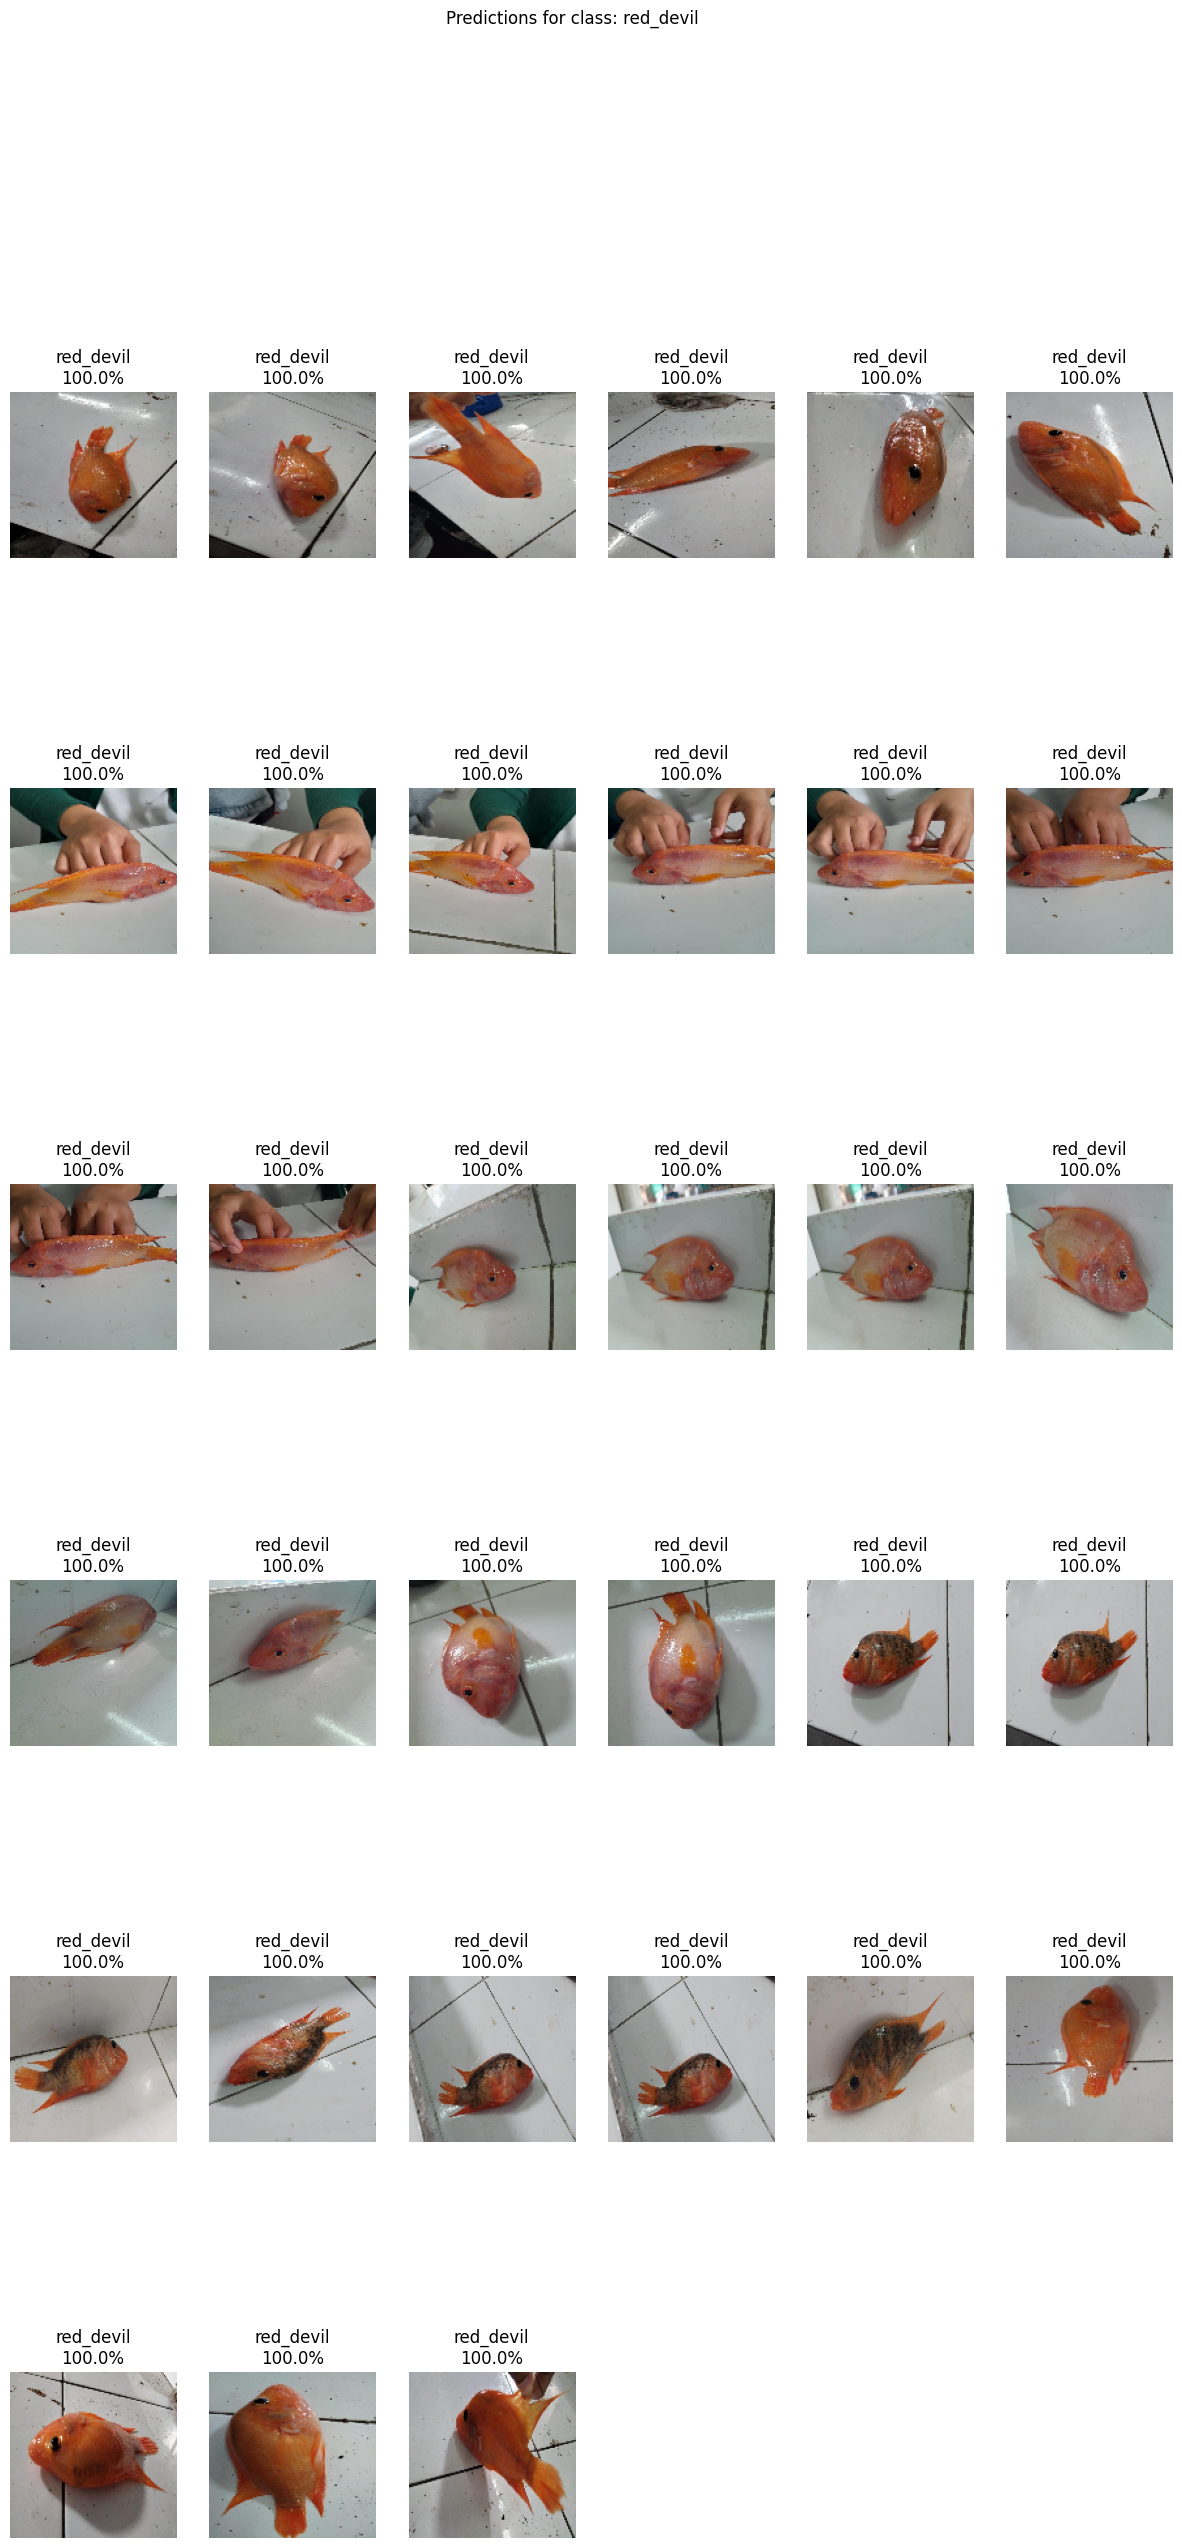


Predictions for class: sepat
Processing dataset/test/sepat\Sepat-104_png_jpg.rf.c8efe00703ee19d384763c8a05f1b4f6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/sepat\Sepat-105_png_jpg.rf.e07125ea47295be33fcbe35134c37fc6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Processing dataset/test/sepat\Sepat-115_png_jpg.rf.10ef20970ea1c9e1857d1192fa523831.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Processing dataset/test/sepat\Sepat-117_png_jpg.rf.dfe4e7f8212150cc64d5ddef0e09aaf1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing dataset/test/sepat\Sepat-15_png_jpg.rf.29fb2d9e7813596912e320f4e4017b8a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing dataset/test/sepat\Sepat-16_png_jpg.rf.eeed7dcbc9bb558bc6056c1e9964eb61.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processing dataset/test/sepat\Sepat-176_jpg.rf.b6caed48284f4995afd08e63b1ee04ce.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Processing dataset/test/sepat\Sepat-184_jpg.rf.ccc8af4b661e42903d254dc517

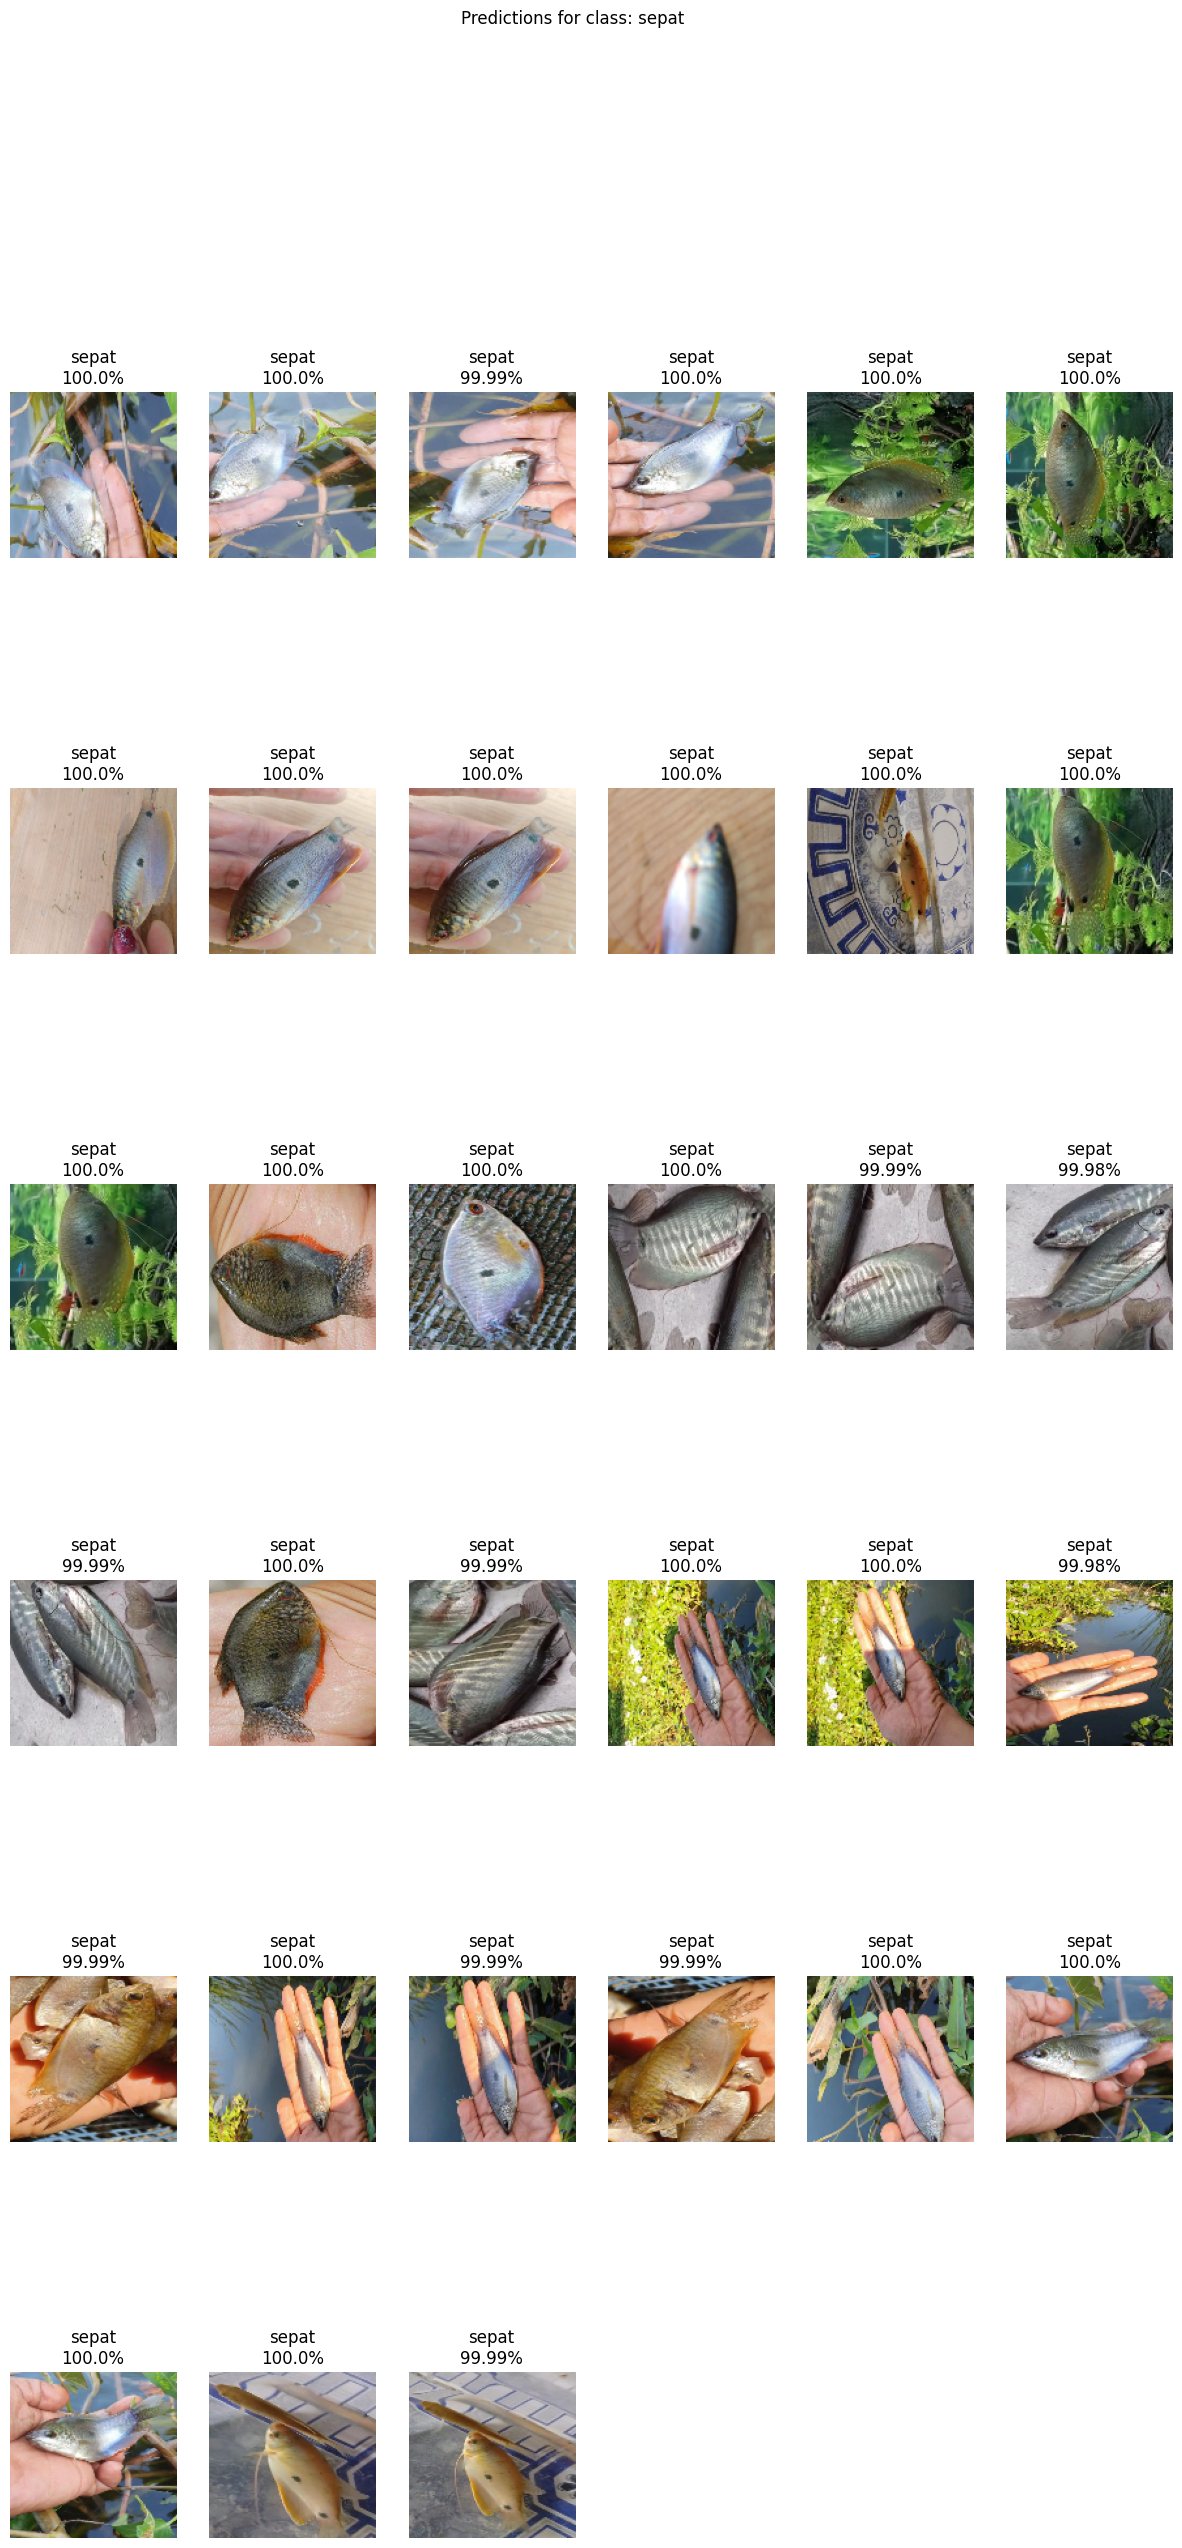

In [130]:
# Load model
model_path = '../model/my_model.keras' 
loaded_model = load_model(model_path)

# Tentukan ukuran gamba
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    return img, label, round(probability * 100, 2)

def predict_images_from_class(class_folder, model):
    images = []
    labels = []
    probabilities = []

    # Ambil semua gambar dari folder kelas tertentu
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            print(f"Processing {img_path}...")
            img, label, probability = predict_image(img_path, model)
            images.append(img)
            labels.append(label)
            probabilities.append(probability)

    return images, labels, probabilities

# Path ke folder dataset
dataset_path = 'dataset/test/'

# Daftar kelas
classes = ['mujahir', 'red_devil', 'sepat']

# Prediksi gambar dari setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    print(f"\nPredictions for class: {class_name}")
    
    images, labels, probabilities = predict_images_from_class(class_folder, loaded_model)
    
    # Tampilkan semua gambar dalam satu plot
    max_images_per_row = 6
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row  # Hitung jumlah baris yang diperlukan

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(len(images)):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{labels[i]}\n{probabilities[i]}%")
    
    plt.suptitle(f"Predictions for class: {class_name}")
    plt.show()

In [131]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE= (64, 64)

model_path = '../model/my_model.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}, Probability: {round(probability * 100, 2)}%")
    plt.show()

    print(f"Label: {label}")
    print(f"Probability: {round(probability * 100, 2)}%")

# Path ke gambar

img_path = 'new_data/ikan-red-devil-3137882226.webp'

# img_path = 'new_data/Ikan-Sepat.jpg'




# img_path = 'dataset/test/sepat/Sepat-82_png_jpg.rf.e732f4f00346193a2229b0dd0316526e.jpg'
# img_path = 'dataset/test/mujahir/5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg'

# img_path = 'new_data/ikan-red-devil-3137882226.jpg'
# img_path = 'new_data/Oreo_nilo_071011-0507_F_jtg.jpg'
# img_path = 'new_data/ikan-mujair1.jpg'
# img_path = 'new_data/qa1  (6).jpg'





# Prediksi gambar
predict_image(img_path, loaded_model)


ValueError: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(1, 64, 64, 3)

In [ ]:
# # Fungsi untuk prediksi gambar baru
# def predict_image(image_path, model):
#     # Baca dan preprocess gambar
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, IMG_SIZE)
    
#     # Terapkan preprocessing
#     processed_img = image_preprocessing(img)
    
#     # Normalisasi
#     processed_img = processed_img / 255.0
    
#     # Expand dimensions
#     processed_img = np.expand_dims(processed_img, axis=0)
    
#     # Prediksi
#     prediction = model.predict(processed_img)
#     predicted_class = np.argmax(prediction[0])
#     confidence = prediction[0][predicted_class]
    
#     # Visualisasi
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
#     ax1.imshow(img)
#     ax1.set_title('Gambar Asli')
#     ax1.axis('off')
    
#     ax2.imshow(processed_img[0])
#     ax2.set_title(f'Preprocessed\nPrediksi: {list(labels)[predicted_class]}\nConfidence: {confidence:.2f}')
#     ax2.axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     return list(labels)[predicted_class], confidence

# # Contoh penggunaan
# example_image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg"
# if os.path.exists(example_image_path):
#     predicted_class, confidence = predict_image(example_image_path, model)
#     print(f"Predicted class: {predicted_class}")
#     print(f"Confidence: {confidence:.2f}")
# else:
#     print("File tidak ditemukan. Pastikan path gambar benar.")

In [ ]:
# import numpy as np
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # 1. Muat model
# loaded_model = load_model('../model/my_model.keras')

# # 2. Muat gambar (ganti 'path_to_image.jpg' dengan path ke gambar Anda)
# image_path = 'new_data/ikan-mujair1.jpg'
# image = load_img(image_path, target_size=(100, 150))  # Sesuaikan ukuran target dengan model Anda

# # 3. Ubah gambar menjadi array numpy
# image_array = img_to_array(image)

# # 4. Normalisasi gambar (jika model Anda memerlukan normalisasi, biasanya [0, 1])
# image_array = image_array / 255.0

# # 5. Tambahkan dimensi batch karena model memerlukan input dalam bentuk batch
# image_array = np.expand_dims(image_array, axis=0)

# # 6. Prediksi menggunakan model
# predictions = loaded_model.predict(image_array)

# # 7. Interpretasi hasil prediksi
# print("Predictions:", predictions)

In [ ]:
# Misalnya, jika model Anda adalah classifier dengan label tertentu
labels = ['mujahir', 'red_devil', 'sepat']  # Ganti dengan label model Anda
predicted_label = labels[np.argmax(predictions)]
print(f"Predicted label: {predicted_label}")


Predicted label: mujahir
